In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np

In [2]:
# ax = sns.boxplot(x="day", y="total_bill", data=tips, palette="Set2")
# ax.set_title('test, test, test')

In [3]:
def raw_data_to_dataframe(gpu_data_path, cpu_data_path):
    """
    transfer raw data from test to pandas dataframe 
    example data frame: 
    [put_time]  [sender_num]  [platform]
    0.001           10            GPU-MPI
    0.0001          10            OPEN-MPI 
    ...  
    """
    pd_data = pd.DataFrame(columns = ['put_time', 'sender_num', 'platform'])
    # demo 
    # pd_data = pd_data.append({'sending_time': 0.001, 'thread_num': 10, 'platform': 'GPU-MPI'}, ignore_index=True)
    # pd_data = pd_data.append({'sending_time': 0.0001, 'thread_num': 10, 'platform': 'OPEN-MPI'}, ignore_index=True)

    # read gpu test file
    file = open(gpu_data_path, 'r')
    for line in file.readlines():
        elements = line.strip().split()
        # if the line not starts with '#', then ignored
        if len(elements) == 0 or not elements[0] == '#':
            continue

        row = {
            'put_time': float(elements[4]), 
            'total_time': float(elements[5]), 
            'sender_num': int(elements[1]), 
            'platform': 'GPU-MPI'
        }
        pd_data = pd_data.append(row, ignore_index=True)
    file.close()

    # read cpu test file 
    file = open(cpu_data_path, 'r')
    for line in file.readlines():
        elements = line.strip().split()
        # if the line not starts with '#', then ignored
        if len(elements) == 0 or not elements[0] == '#':
            continue

        row = {
            'put_time': float(elements[4]), 
            'total_time': float(elements[5]), 
            'sender_num': int(elements[1]), 
            'platform': 'OPEN-MPI'
        }
        pd_data = pd_data.append(row, ignore_index=True)
    file.close()

    return pd_data

In [4]:
# read data 
data_path_gpu = 'benchmark_121_put_passive_cuda_640_100_600.txt'
data_path_cpu = 'benchmark_121_put_passive_cpu_640_100_600.txt'
thread_time_data = raw_data_to_dataframe(data_path_gpu, data_path_cpu)

In [5]:
# generate title for plot 
plot_prefix = data_path_gpu.strip().split('_')[0:-2]
plot_prefix = '-'.join(plot_prefix)
plot_prefix

'benchmark-121-put-passive-cuda-640'

In [6]:
def data_validity_check(data):
    """
    check data validity from the log. 
    e.g. data point number.
    """
    # filter out platform data 
    cuda_mpi_data = data[data['platform'] == 'GPU-MPI']
    cpu_mpi_data = data[data['platform'] == 'OPEN-MPI']
    
    # create empty container
    result = data.drop(index=range(0, len(data)))
    
    # rule 1: data point number for each thread_num should be the same. 
    thread_num = data['sender_num'].unique()
    print('rule 1 check, sender_num = {}'.format(thread_num))
    expected = len(cuda_mpi_data[cuda_mpi_data['sender_num'] == thread_num[0]])  # init with fisrt #(first cuda data point)
    for n in thread_num:
        _cpu = cpu_mpi_data[cpu_mpi_data['sender_num'] == n]
        _cuda = cuda_mpi_data[cuda_mpi_data['sender_num'] == n]
        len_cpu = len(cpu_mpi_data[cpu_mpi_data['sender_num'] == n])
        len_cuda = len(cuda_mpi_data[cuda_mpi_data['sender_num'] == n])
        if len_cpu > expected:
            print('[warning] [cpu] sender_num = {}, sample {} out of {}'.format(n, expected, len_cpu))
            _cpu = _cpu.sample(n=expected)
        if len_cuda > expected:
            print('[warning] [cuda] sender_num = {}, sample {} out of {}'.format(n, expected, len_cuda))
            _cuda = _cuda.sample(n=expected)
        if len_cpu < expected:
            raise Exception('not enough data for [cpu] sender_num = {}, expect {} but get {}'.format(n, expected, len_cpu))
        if len_cuda < expected:
            raise Exception('not enough data for [cuda] sender_num = {}, expect {} but get {}'.format(n, expected, len_cuda))
        
        result = pd.concat([result, _cpu, _cuda])
    
    return result

In [7]:
thread_time_data

,put_time,sender_num,platform,total_time
0,0.000928,1,GPU-MPI,0.092878
1,0.000929,1,GPU-MPI,0.092968
2,0.000930,1,GPU-MPI,0.093079
3,0.000930,1,GPU-MPI,0.093028
4,0.000930,1,GPU-MPI,0.093003
...,...,...,...,...
9595,0.000743,30,OPEN-MPI,0.210290
9596,0.000641,30,OPEN-MPI,0.245772
9597,0.000563,30,OPEN-MPI,0.220015
9598,0.000004,30,OPEN-MPI,0.232009


In [8]:
# x = data_validity_check(thread_time_data)
back_up = thread_time_data.copy()  # leave a backup 
# thread_time_data = x
back_up

,put_time,sender_num,platform,total_time
0,0.000928,1,GPU-MPI,0.092878
1,0.000929,1,GPU-MPI,0.092968
2,0.000930,1,GPU-MPI,0.093079
3,0.000930,1,GPU-MPI,0.093028
4,0.000930,1,GPU-MPI,0.093003
...,...,...,...,...
9595,0.000743,30,OPEN-MPI,0.210290
9596,0.000641,30,OPEN-MPI,0.245772
9597,0.000563,30,OPEN-MPI,0.220015
9598,0.000004,30,OPEN-MPI,0.232009


Text(0.5, 1.0, 'benchmark-121-put-passive-cuda-640-put_time')

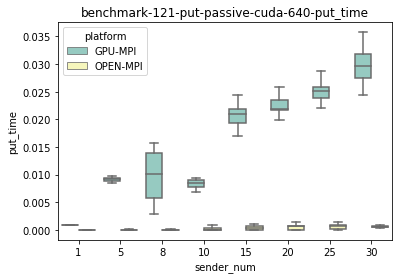

In [9]:
# general box plot
ax = sns.boxplot(x="sender_num", y="put_time", hue='platform', data=thread_time_data, palette="Set3", showfliers=False, whis=1.5)
ax.set_title(f'{plot_prefix}-put_time')

Text(0.5, 1.0, 'benchmark-121-put-passive-cuda-640-total_time')

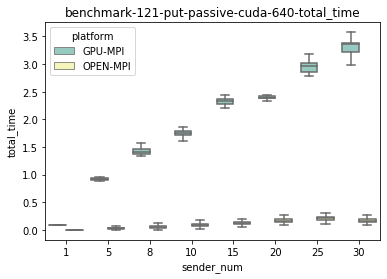

In [10]:
# general box plot for total time
ax = sns.boxplot(x="sender_num", y="total_time", hue='platform', data=thread_time_data, palette="Set3", showfliers=False, whis=1.5)
ax.set_title(f'{plot_prefix}-total_time')

In [11]:
# line plot for put time
def line_plot_median_quartile(time_key):
    ax = sns.lineplot(x="sender_num", y=time_key, hue='platform', data=thread_time_data, palette="Set2", estimator=np.median, ci=None)
    # generate quatile bound manually
    for p in thread_time_data['platform'].unique():
        data = thread_time_data[thread_time_data['platform'] == p]
        bounds = data.groupby('sender_num')[time_key].quantile((0.25,0.75)).unstack()
        ax.fill_between(x=bounds.index,y1=bounds.iloc[:,0],y2=bounds.iloc[:,1],alpha=0.1)
    return ax

Text(0.5, 1.0, 'benchmark-121-put-passive-cuda-640-put_time')

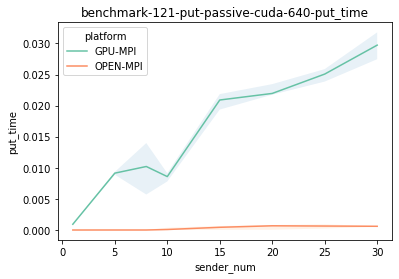

In [16]:
# line plot: put time, median-quartile
ax = line_plot_median_quartile(time_key='put_time')
ax.set_title(f'{plot_prefix}-put_time')

Text(0.5, 1.0, 'benchmark-121-put-passive-cuda-640-total_time')

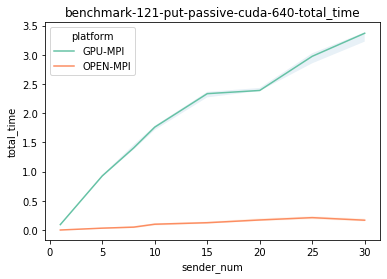

In [13]:
# line plot: total time, median-quartile
ax = line_plot_median_quartile(time_key='total_time')
ax.set_title(f'{plot_prefix}-total_time')

Text(0.5, 1.0, 'benchmark-121-put-passive-cuda-640-cuda_mpi-put_time')

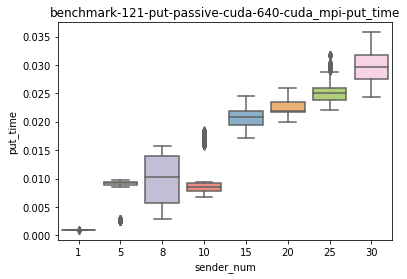

In [14]:
# subplot for gpu put time only 
data_gpu = thread_time_data[thread_time_data['platform'] == 'GPU-MPI']
ax = sns.boxplot(x="sender_num", y="put_time", data=data_gpu, palette="Set3", showfliers=True) 
ax.set_title(f'{plot_prefix}-cuda_mpi-put_time')

Text(0.5, 1.0, 'benchmark-121-put-passive-cuda-640-open_mpi-put_time')

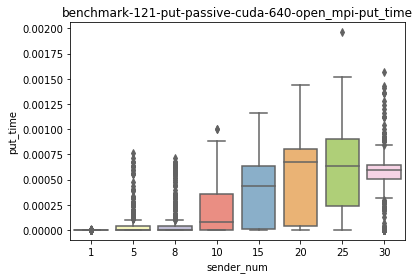

In [15]:
# subplot for cpu put time only 
data_cpu = thread_time_data[thread_time_data['platform'] == 'OPEN-MPI']
ax = sns.boxplot(x="sender_num", y="put_time", data=data_cpu, palette="Set3")
ax.set_title(f'{plot_prefix}-open_mpi-put_time')